# Overview

1. Contesto
2. Modelli Applicati e loro valutazione
3. Scelta dell'approccio e analisi del risultato

#  1. Contesto

La cardiotocografia è la tecnica che aiuta i medici a tracciare la frequenza cardiaca del feto,che include la misurazione delle accelerazioni, decelerazioni e variabilità, con l'aiuto delle contrazioni uterine. Può essere sfruttata per classificare lo stato di salute del feto.
Il data set che è stato utilizzato in questo progetto è costituito da 2126 records ognuno deiquali è stato associato da un team di Ostetrici ad una classe di stato fetale specifica. Abbiamo:

- 1655 Normali
- 295 Sospetti
- 176 Patologici



**Objective**

L’obiettivo è quello di costruire un algoritmo di classificazione. Nel dettaglio ci troviamo di fronte ad un problema supervisionato di Classificazione Multiclasse


**Data Schema**

Attribute Information:

LB - FHR baseline (beats per minute)
AC - # of accelerations per second
FM - # of fetal movements per second
UC - # of uterine contractions per second
DL - # of light decelerations per second
DS - # of severe decelerations per second
DP - # of prolongued decelerations per second
ASTV - percentage of time with abnormal short term variability
MSTV - mean value of short term variability
ALTV - percentage of time with abnormal long term variability
MLTV - mean value of long term variability
Width - width of FHR histogram
Min - minimum of FHR histogram
Max - Maximum of FHR histogram
Nmax - # of histogram peaks
Nzeros - # of histogram zeros
Mode - histogram mode
Mean - histogram mean
Median - histogram median
Variance - histogram variance
Tendency - histogram tendency
CLASS - FHR pattern class code (1 to 10)
NSP - fetal state class code (N=normal; S=suspect; P=pathologic)

# 2. Modelli Applicati e loro valutazione

In [69]:
#librerie
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

SEED = 42

**Dataset Loading and Schema Review**

In [3]:
path_input = "data"
dataset = "dataset.csv"

df = pd.read_csv(path_input + "/" + dataset, sep = ";", decimal = ",")

In [4]:
df.isnull().sum()

LB          0
AC          0
FM          0
UC          0
DL          0
DS          0
DP          0
ASTV        0
MSTV        0
ALTV        0
MLTV        0
Width       0
Min         0
Max         0
Nmax        0
Nzeros      0
Mode        0
Mean        0
Median      0
Variance    0
Tendency    0
NSP         0
dtype: int64

<AxesSubplot:xlabel='NSP', ylabel='Count'>

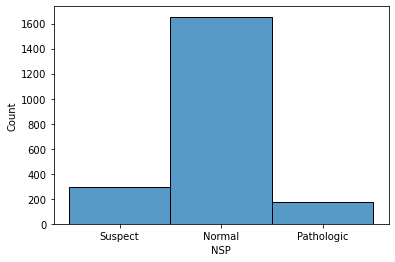

In [5]:
#Display historam of target Class
sns.histplot(df['NSP'])

- Valori Nulli
    - Non sono presenti valori nulli nelle fauture


- Target Class
    - La class target non è distribuita uniformemente essendoci un maggior numero di valori Normali. Nella fase di train test split ne dovrò tenere conto

**Applicazione del Modello**

Non avendo piena conoscenza dei e degli attributi applico direttamente un algoritmo di classificazione facile, nello specifico un albero decisionale. La colonna target è NSP. Il data set viene splittato stratificando sulla colonna target dato che essa non è distribuita in maniera omogena.

I dati non hanno la stessa scala e perciò standardizzo applicando un RobustScaler

In [6]:
x_data = df.drop(columns = ["NSP"])

feautures_name = x_data.columns

#Perchè RobustScaler?
x_standard = RobustScaler().fit_transform(x_data.values)
x = pd.DataFrame(x_standard)
x.columns = feautures_name
y = df["NSP"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=SEED,stratify=y)

In [7]:
clf_DTC = DecisionTreeClassifier(random_state=SEED)
clf_DTC.fit(X_train, y_train)

y_pred_DTC = clf_DTC.predict(X_test)

In [9]:
# f1 Pesato

print("f1_weighted:",metrics.f1_score(y_test, y_pred_DTC ,average='weighted'))

# Accuratezza

print("accuracy:",metrics.accuracy_score(y_test, y_pred_DTC))

# Classification Report
print(metrics.classification_report(y_pred_DTC, y_test))

f1_weighted: 0.9132575879160922
accuracy: 0.9153605015673981
              precision    recall  f1-score   support

      Normal       0.96      0.94      0.95       507
  Pathologic       0.94      0.93      0.93        54
     Suspect       0.66      0.75      0.70        77

    accuracy                           0.92       638
   macro avg       0.85      0.87      0.86       638
weighted avg       0.92      0.92      0.92       638



Risultati del modello sono gia sufficenti, vedo se migliorano applicando un algoritmo che combina pià decision tree, il RandomForestClassifier

In [10]:
clf_RMC = RandomForestClassifier(random_state=SEED)
clf_RMC.fit(X_train, y_train)
y_pred_RMC = clf_RMC.predict(X_test)

In [11]:
# f1 Pesato

print("f1_weighted:",metrics.f1_score(y_test, y_pred_RMC ,average='weighted'))

# Accuratezza

print("accuracy:",metrics.accuracy_score(y_test, y_pred_RMC))

# Classification Report

print(metrics.classification_report(y_pred_RMC, y_test))

f1_weighted: 0.9428251641276724
accuracy: 0.9435736677115988
              precision    recall  f1-score   support

      Normal       0.97      0.96      0.97       501
  Pathologic       0.96      0.91      0.94        56
     Suspect       0.78      0.85      0.82        81

    accuracy                           0.94       638
   macro avg       0.91      0.91      0.91       638
weighted avg       0.95      0.94      0.94       638



Miglioramento dei risultati, il Random Forest funziona meglio ma la base di partenza era gia ottima

# 2. Scelta finale dell dell'approccio e analisi del risultato

Essendo un problema di natura medica potrebbe essere utile fornire un modello che abbiamo una precisione minore ma che sia di più facile interpretazione. Per fare questo seleziono gli attributi più importanti e provo a fornire direttamente l'albero decisionale all'utente.

In [17]:
def plot_importance(importance,names,model_type):
  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  feature_most_imp = list(fi_df[fi_df['feature_importance']>0]['feature_names'].values)

  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + ' FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

  return feature_most_imp

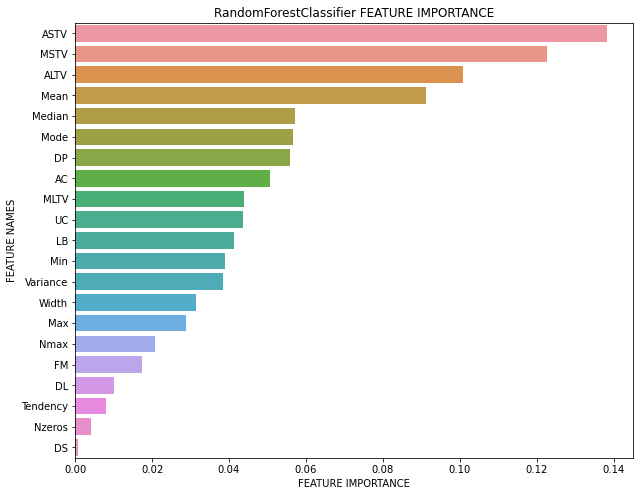

In [18]:
feature_to_select = plot_importance(importance=clf_RMC.feature_importances_,
                                    names=feautures_name,
                                    model_type= clf_RMC.__class__.__name__)

In [60]:
feature_to_select = feature_to_select[:4]

In [61]:
feature_to_select

['ASTV', 'MSTV', 'ALTV', 'Mean']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(x_data[feature_to_select], y, test_size=0.3, random_state=SEED,stratify=y)

clf_DTC_FS = DecisionTreeClassifier(random_state=SEED, max_depth= 3)
clf_DTC_FS .fit(X_train, y_train)
y_pred_DTC_FS = clf_DTC_FS.predict(X_test)

In [63]:
# f1 Pesato

print("f1_weighted:",metrics.f1_score(y_test, y_pred_DTC_FS ,average='weighted'))

# Accuratezza

print("accuracy:",metrics.accuracy_score(y_test, y_pred_DTC_FS))

# Classification Report

print(metrics.classification_report(y_pred_DTC_FS, y_test))

f1_weighted: 0.8952073603289383
accuracy: 0.8981191222570533
              precision    recall  f1-score   support

      Normal       0.96      0.92      0.94       514
  Pathologic       0.83      0.92      0.87        48
     Suspect       0.61      0.71      0.66        76

    accuracy                           0.90       638
   macro avg       0.80      0.85      0.82       638
weighted avg       0.91      0.90      0.90       638



Accuratezza rimane comunque ottima quindi visualizzo il grafo per capire le soglie da applicare e studiare l'output decisionale'

In [64]:
def trees_analysis(clf):
  n_nodes = clf.tree_.node_count
  children_left = clf.tree_.children_left
  children_right = clf.tree_.children_right
  feature = clf.tree_.feature
  threshold = clf.tree_.threshold

  node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
  is_leaves = np.zeros(shape=n_nodes, dtype=bool)
  stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
  while len(stack) > 0:
      # `pop` ensures each node is only visited once
      node_id, depth = stack.pop()
      node_depth[node_id] = depth

      # If the left and right child of a node is not the same we have a split
      # node
      is_split_node = children_left[node_id] != children_right[node_id]
      # If a split node, append left and right children and depth to `stack`
      # so we can loop through them
      if is_split_node:
          stack.append((children_left[node_id], depth + 1))
          stack.append((children_right[node_id], depth + 1))
      else:
          is_leaves[node_id] = True

  print(
      "The binary tree structure has {n} nodes and has "
      "the following tree structure:\n".format(n=n_nodes)
  )
  for i in range(n_nodes):
      if is_leaves[i]:
          print(
              "{space}node={node} is a leaf node.".format(
                  space=node_depth[i] * "\t", node=i
              )
          )
      else:
          print(
              "{space}node={node} is a split node: "
              "go to node {left} if X[:, {feature}] <= {threshold} "
              "else to node {right}.".format(
                  space=node_depth[i] * "\t",
                  node=i,
                  left=children_left[i],
                  feature=feature[i],
                  threshold=threshold[i],
                  right=children_right[i],
              )
          )

In [65]:
trees_analysis(clf_DTC_FS)

The binary tree structure has 15 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 1] <= 0.550000011920929 else to node 8.
	node=1 is a split node: go to node 2 if X[:, 2] <= 68.5 else to node 5.
		node=2 is a split node: go to node 3 if X[:, 0] <= 59.5 else to node 4.
			node=3 is a leaf node.
			node=4 is a leaf node.
		node=5 is a split node: go to node 6 if X[:, 1] <= 0.45000000298023224 else to node 7.
			node=6 is a leaf node.
			node=7 is a leaf node.
	node=8 is a split node: go to node 9 if X[:, 3] <= 107.5 else to node 12.
		node=9 is a split node: go to node 10 if X[:, 0] <= 25.0 else to node 11.
			node=10 is a leaf node.
			node=11 is a leaf node.
		node=12 is a split node: go to node 13 if X[:, 2] <= 6.5 else to node 14.
			node=13 is a leaf node.
			node=14 is a leaf node.


Prossimo passo Visualizzare grafico conm Graphviz

In [75]:
list(y.unique())

['Suspect', 'Normal', 'Pathologic']

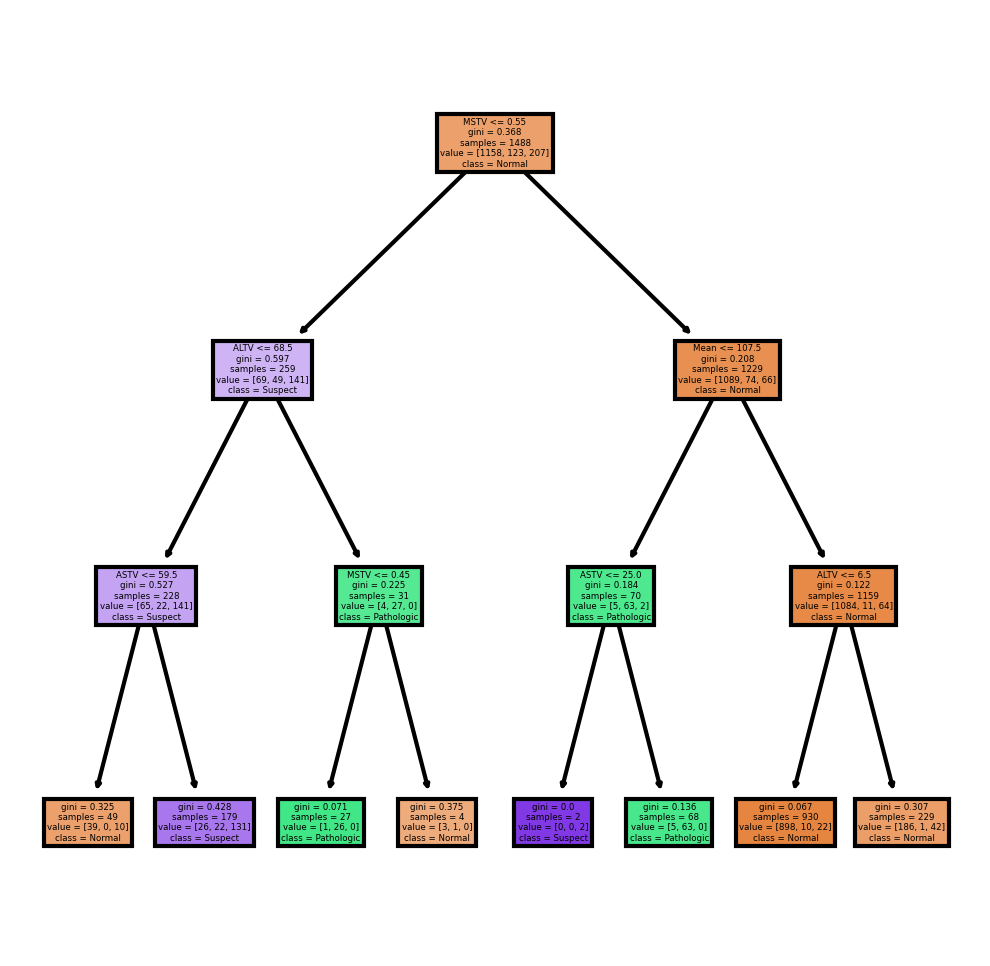

In [79]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(clf_DTC_FS,
               feature_names = feature_to_select,
               class_names=["Normal", "Pathologic", "Suspect"],
               filled = True);
fig.savefig('AlberoDecisionale.png')

Salvare il modello

In [ ]:
filename = 'finalized_model.sav'
#Da importare ancora e scaricare con PIP
joblib.dump(clf_DTC_FS, "./random_forest_2_65.joblib")